**Description** Distributions of conditional effects to demonstrate that we're not just
averaging out real negative and positive effects.

This is the distribution of—

$$
\begin{align*}
\frac{\bar{\hat{Y}}_{\cdot \cdot \cdot 1} - \bar{\hat{Y}}_{\cdot \cdot \cdot 0}}{n}
\end{align*}
$$

—the difference between the treatment ($1$) and control ($0$) grand means. The mean is
taken across LM types, classification tasks, and their subsamples. We could produce
conditional plots for each of these groups, but rn I want to summarize the results.

**Required data**: posterior samples are stored in `main_*.nc` files. Obtain them by
running the notebooks in [`../fit_posteriors/`](../fit_posteriors/). Unfortunately all
of the inference data was saved (including for parameters we don't care about), so these
files are in the 10s of GBs. I'm trying to find a cheap and long-term way to share
these. Sorry.

**Estimated runtime**: 2 min.

In [1]:
import os
import sys
from typing import Literal

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import polars as pl
import seaborn as sns
from tqdm.auto import tqdm

# sys hack to import from parent
sys.path.append(os.path.abspath(os.path.join("..")))
import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

In [113]:
effect_to_name = {
    "control": "pretraining boost",
    "treatment": "evaluation bias",
}

In [112]:
effect_to_renamer = {
    "treatment": {"treatment": "test", "control": "extra"},
    "control": {"treatment": "extra", "control": "base"},
}

# Input

In [72]:
num_train: Literal[50, 100] = 50

In [73]:
thingy: Literal["regular", "zero_shot", "gpt2-epochs-2"] = "regular"

_plot_title = f"$m={{{num_train}}}$ training observations"

if thingy == "regular":
    # num_tests: tuple[int] = (50, 100, 200, 500)
    num_tests: tuple[int] = (500,)
    accuracies_home_dir: str = os.path.join("..", "accuracies_from_paper")
    netcdfs_path: str = os.path.join("..", "netcdfs")
    title = _plot_title
elif thingy == "zero_shot":
    num_tests: tuple[int] = (100,)
    accuracies_home_dir: str = os.path.join("..", "accuracies_zero_shot")
    netcdfs_path: str = os.path.join("..", "netcdfs", "zero-shot")
    title = "Mistral 7B, zero-shot"
elif thingy == "gpt2-epochs-2":
    num_tests: tuple[int] = (50,)
    accuracies_home_dir: str = os.path.join("..", "accuracies_gpt2_epochs_2")
    netcdfs_path: str = os.path.join("..", "netcdfs", "gpt2-epochs-2")
    title = f"{_plot_title} (overtraining)"
else:
    raise ValueError("Not a valid thingy")

# Marginalize

In [74]:
num_test_to_diffs_df: dict[int, pl.DataFrame] = {}
for num_test in tqdm(num_tests, "Processing treatment and control datasets"):
    num_correct_df = utils.load_all_num_correct(
        os.path.join(accuracies_home_dir, f"m{num_train}"), num_test
    )
    effect_to_diffs_df = {}
    for effect in effect_to_name:
        az_summary = az.from_netcdf(
            os.path.join(
                netcdfs_path,
                f"m{num_train}",
                f"main_m{num_train}_n{num_test}_{effect}.nc",
            )
        )
        break
    break

Processing treatment and control datasets:   0%|          | 0/1 [00:00<?, ?it/s]

In [75]:
import xarray as xr

posterior_predictive: xr.DataArray = az.extract(
    az_summary, group="posterior_predictive"
)

predictions = posterior_predictive["p(num_correct, num_test)"]

_dfs: list[pl.DataFrame] = []

for draw in tqdm(range(predictions.shape[1])):
    yhat = predictions[:, draw]
    num_correct_df_simulated = utils.num_correct_df_from_predicions(
        num_correct_df, yhat.to_numpy()
    )
    grouped = (
        num_correct_df_simulated
        # .group_by(["num_test", "lm_type", "dataset"], maintain_order=True)
        # .agg((pl.col(["treatment", "control"]) / num_test).mean())
        .with_columns(pl.lit(draw).alias("draw"))
    )
    _dfs.append(grouped)
df: pl.DataFrame = pl.concat(_dfs)
del _dfs

  0%|          | 0/4000 [00:00<?, ?it/s]

In [76]:
df

num_test,lm_type,dataset,control,treatment,draw
i32,str,str,i64,i64,i32
500,"""bert""","""FRENK-hate-en""",297,304,0
500,"""bert""","""FRENK-hate-en""",239,248,0
500,"""bert""","""FRENK-hate-en""",311,308,0
500,"""bert""","""FRENK-hate-en""",314,310,0
500,"""bert""","""FRENK-hate-en""",273,274,0
…,…,…,…,…,…
500,"""gpt2""","""yelp_review_fu…",104,107,3999
500,"""gpt2""","""yelp_review_fu…",124,121,3999
500,"""gpt2""","""yelp_review_fu…",142,143,3999


In [82]:
pred_obs_effect = (
    df.group_by("lm_type", "dataset")
    .agg(((pl.col("treatment") - pl.col("control")) / num_test).mean().alias("pred"))
    .join(
        num_correct_df.group_by("lm_type", "dataset").agg(
            (((pl.col("test") - pl.col("extra")) / num_test).mean()).alias("obs")
        ),
        on=["lm_type", "dataset"],
    )
)

In [83]:
pred_obs = (
    df.group_by("lm_type", "dataset")
    .agg((pl.col("control").mean() / num_test).alias("pred"))
    .join(
        num_correct_df.group_by("lm_type", "dataset").agg(
            (pl.col("base").mean() / num_test).alias("obs")
        ),
        on=["lm_type", "dataset"],
    )
)

In [109]:
def plot_calibration(data: pl.DataFrame) -> plt.Axes:
    data = data.with_columns(pl.col("lm_type").replace(utils.lm_type_to_name))
    with sns.color_palette("husl", 2):
        ax = sns.scatterplot(data=data, x="obs", y="pred", hue="lm_type", alpha=0.8)
    xlim = ax.get_xlim()
    plt.plot(xlim, xlim, linestyle="--", color="black", label="Perfect calibration")
    plt.legend()
    return ax

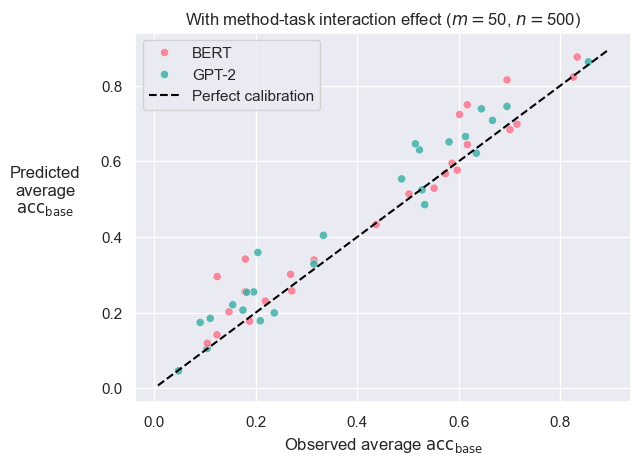

In [110]:
ax = plot_calibration(pred_obs)
ax.set_xlabel(f"Observed average {utils.texalo('base')}")
ax.set_ylabel(
    f"Predicted\naverage\n{utils.texalo('base')}", rotation="horizontal", labelpad=40
)
ax.set_title(
    f"With method-task interaction effect ($m = ${num_train}, $n = ${num_test})"
);

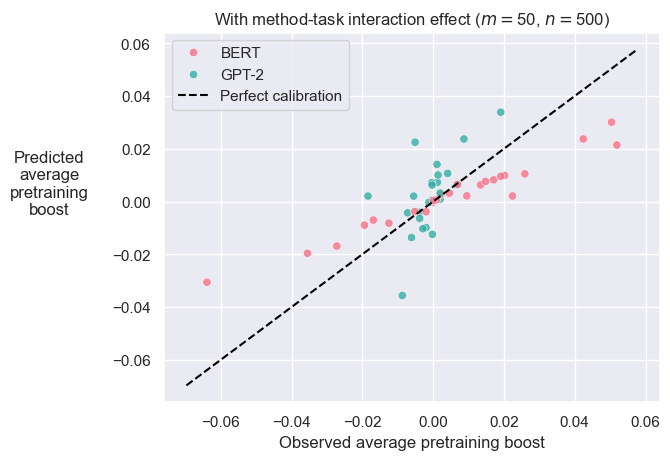

In [111]:
ax = plot_calibration(pred_obs_effect)
ax.set_xlabel("Observed average pretraining boost")
ax.set_ylabel(
    "Predicted\naverage\npretraining\nboost", rotation="horizontal", labelpad=45
)
ax.set_title(
    f"With method-task interaction effect ($m = ${num_train}, $n = ${num_test})"
);

In [87]:
grouped_preds = (
    df.group_by("num_test", "lm_type", "dataset", "draw")
    .mean()
    .with_columns(
        ((pl.col("treatment") - pl.col("control")) / num_test).alias("effect")
    )
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


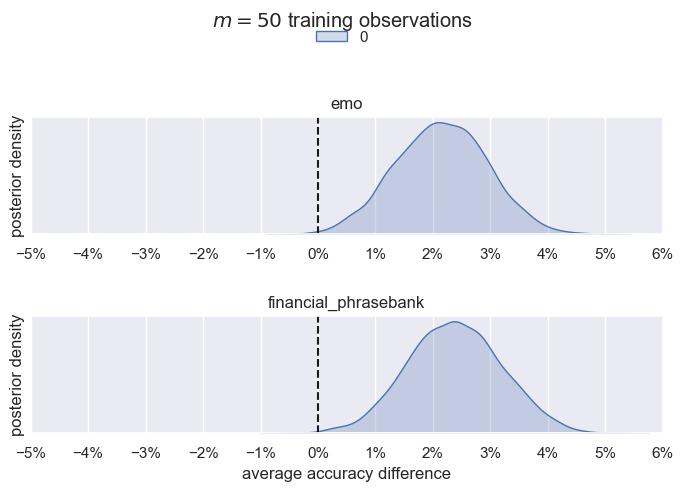

In [88]:
lm_type = "bert"
selected_datasets = ["emo", "financial_phrasebank"]

fig, axes = plt.subplots(nrows=len(selected_datasets), ncols=1)
fig.set_size_inches(7, (2 * len(selected_datasets)))

xlim = (-0.05, 0.05)

xticks = np.arange(xlim[0], xlim[1] + 0.01, 0.01)
# every 0.01

axes: list[plt.Axes] = [axes] if len(selected_datasets) == 1 else axes
for subplot_idx, dataset in enumerate(selected_datasets):
    ax = axes[subplot_idx]
    _ = ax.set_xlim(xlim)
    effect = grouped_preds.filter(
        (pl.col("lm_type") == lm_type).and_(pl.col("dataset") == dataset)
    ).select("effect")
    _ = sns.kdeplot(ax=ax, data=effect, fill=True)
    ax.axvline(0, linestyle="dashed", color="k")
    _ = ax.set_ylabel("posterior density")
    _ = ax.set_yticks([])
    _ = ax.set_xticks(xticks)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    _ = ax.set_title(
        # f"$m={{{num_train}}}$ training observations, "
        # f"$n={{{num_test}}}$ test observations"
        dataset
    )

_ = ax.set_xlabel("average accuracy difference")

title_y_pos = 1.07 if thingy == "regular" else 1.25
fig.suptitle(title, y=title_y_pos)

fig.legend(
    handles=reversed(ax.legend_.legend_handles),
    labels=reversed([t.get_text() for t in ax.legend_.get_texts()]),
    ncol=2,
    loc="center",
    frameon=False,
    bbox_to_anchor=(0.5, 1.0),
)

for ax in axes:
    ax.legend().set_visible(False)

fig.tight_layout()
plt.subplots_adjust(bottom=0.01)